# Natural Language Processing - Apple Sentiment
by Michael Kearns

# Business Understanding

Customer relations and approval is highly valued at the Tech Sales Company (TSC). Currently, TSC sells Apple products and we want to be sure if we should continue to market and supply Apple products to our customers. If customers no longer like Apple, we want to separate ourselves from the brand and show our loyalty to our customers and promote other products. To track what customers do not like about Apple, we plan to develop a natural language processing model that can identify if a customer's post is critical and should be reviewed later. Non critical posts will be considered posts that do not provide negative or useful information that can help show what our customers do not like about Apple. 

# Data Understanding
To train and test this machine learning model, data from [Crowdflower](https://www.kaggle.com/datasets/slythe/apple-twitter-sentiment-crowdflower) will be used. This dataset includes nearly 4,000 X posts that reference Apple from December, 2014. The primary features that will be used are the "Sentiment" and "Text" features that include the posts and that user's sentiment toward Apple, rated from 1-3 scale


## Data Preparation

In [1]:
import pandas as pd
import numpy as np

#import csv file
filename = 'data/Apple-Twitter-Sentiment-DFE.csv'
df = pd.read_csv(filename, encoding="latin1")

#check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   _unit_id              3886 non-null   int64  
 1   _golden               3886 non-null   bool   
 2   _unit_state           3886 non-null   object 
 3   _trusted_judgments    3886 non-null   int64  
 4   _last_judgment_at     3783 non-null   object 
 5   sentiment             3886 non-null   object 
 6   sentiment:confidence  3886 non-null   float64
 7   date                  3886 non-null   object 
 8   id                    3886 non-null   float64
 9   query                 3886 non-null   object 
 10  sentiment_gold        103 non-null    object 
 11  text                  3886 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 337.9+ KB


Only the "sentiment" and "text" columns will be retained for this model. All other columns can be removed.

In [2]:
#Keep relevant columns in dataset.
df = df[['sentiment','text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  3886 non-null   object
 1   text       3886 non-null   object
dtypes: object(2)
memory usage: 60.8+ KB


In [3]:
#Check overall sentiment distribution
print(df['sentiment'].value_counts())

sentiment
3               2162
1               1219
5                423
not_relevant      82
Name: count, dtype: int64


Based on background information provided by the datasource, sentiment is ranked as 1 - Negative, 3 - Neutral, 5 - Positive.

In [4]:
#Check proportion of sentiment values
print(df['sentiment'].value_counts(normalize = True))

sentiment
3               0.556356
1               0.313690
5               0.108852
not_relevant    0.021101
Name: proportion, dtype: float64


Based on the buisness problem, the model is determine if a post is "critical" or "not critical". That makes this a binary problem and the sentiment values need to be adjusted to accommadte a binary classification. 3 or "Neutral" posts will be considered "not critical", and to maintain a balanced distribution, 800 random posts from the 3 classification will be converted to 5 ratings. Then the 5's will be converted to 0's to for simplicity so that model can classify posts as 0 - "not critical" or 1 - "critical". Posts that have a "not_relevant" sentiment will be removed as they only make up 2% of the data set. After this redistribution of data, the model will still have over 2000 posts to train and test on.

In [5]:
#Remove "not_relevant" rows
df = df[df['sentiment']!= 'not_relevant']
#convert sentiment to integers
df['sentiment'] = df['sentiment'].astype(int)

In [6]:
#Randomly convert 800 of the 3's to 5's

# Step 1: Identify rows with a rating of 3
rating_3_indices = df[df['sentiment'] == 3].index

# Step 2: select random group of 800 ratings = 3
np.random.seed(42)
random_subset_indices = np.random.choice(rating_3_indices, size=800, replace=False)

# Step 3: Convert random subset to value = 5
df['sentiment'].loc[random_subset_indices] = 5

#Step 4: Remove remaining rows from df
remaining_indices = df[df['sentiment'] == 3].index
df = df.drop(remaining_indices)

/var/folders/sk/8hr8rsms4cb5y3ryy9w5yplh0000gn/T/ipykernel_75140/1882727535.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'].loc[random_subset_indices] = 5


In [7]:
#Check overall sentiment distribution
print(df['sentiment'].value_counts())

sentiment
5    1223
1    1219
Name: count, dtype: int64


In [8]:
#Convert 5's to 0's
df['sentiment'] = df['sentiment'].replace(5,0)
#Check overall sentiment distribution
print(df['sentiment'].value_counts())

sentiment
0    1223
1    1219
Name: count, dtype: int64


Data needs to simplified and cleaned. Initial steps to preprocess the text will be to convert all letters in a post to lowercase. Mentions, ie. @..., and URLS will be removed. The user mentions will be primarily directed at Apple which is not signifcant as all posts in this data are in reference towards Apple. URLS are long and not semantic content.

In [9]:
#Convert all letters to lowercase
df['text_cleaned'] = df['text'].str.lower()

import re

def clean_text(text):
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.strip()  # Remove extra whitespaces
    return text

# Apply function to the dataset
df['text_cleaned'] = df['text_cleaned'].apply(clean_text)

# Exploratory Data Analysis

To make the text more suitable for a machine learning model, the text needs to be tokenized. This will be done using the **nltk** module. This step will also help us understand common words from user posts.

In [10]:
import nltk
from nltk.probability import FreqDist
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
import string

/Users/michaelkearns/anaconda3/envs/my-learn-env/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
#tokenize text using basic regex pattern
token_pattern = r"(?u)\b\w\w+\b"
tokenizer = RegexpTokenizer(token_pattern)

#apply tokenizer to dataset
df['text_tokenized']=df['text_cleaned'].apply(tokenizer.tokenize)

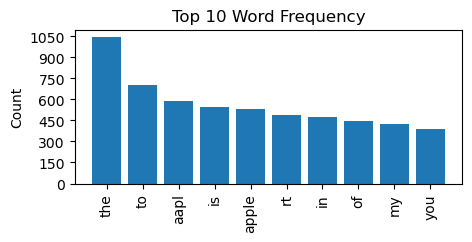

In [12]:
#Create Frequency Distribution of Tokens
text_freq_dist = FreqDist(df['text_tokenized'].explode())

# Plot the top 10 tokens

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def visualize_top_10(freq_dist, title):

    # Extract data for plotting
    top_10 = list(zip(*freq_dist.most_common(10)))
    tokens = top_10[0]
    counts = top_10[1]

    # Set up plot and plot data
    fig, ax = plt.subplots(figsize = (5,2))
    ax.bar(tokens, counts)

    # Customize plot appearance
    ax.set_title(title)
    ax.set_ylabel("Count")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.tick_params(axis="x", rotation=90)
    
visualize_top_10(text_freq_dist, 'Top 10 Word Frequency')

plt.savefig("./images/df_10word_freq.png", dpi=150)

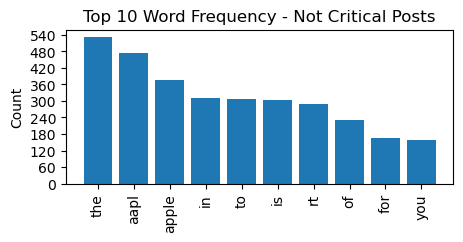

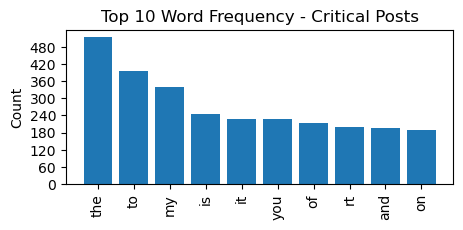

In [13]:
# Visualize top 10 tokens per Critical or Not Critical
def visualize_top_ten_tokens_per_sentiment(sentiment,rating,text):
    freq_dist = FreqDist(df[df[sentiment] == rating][text].explode())
    if rating == 0:
        title = 'Top 10 Word Frequency - Not Critical Posts'
    else: 
        title = 'Top 10 Word Frequency - Critical Posts'
    return  visualize_top_10(freq_dist, title)

for i in range(0,2):
    visualize_top_ten_tokens_per_sentiment('sentiment',i,'text_tokenized')
    plt.savefig(f"./images/df_10word_freq_rating{i}.png", dpi=150)
    

Stopwords seem to be very repeatable among the two types of posts. They should me removed to make the tokens more distinct.

In [14]:
#download stopwords to remove
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english')

#'aapl' and 'apple' will be very repetive in these posts so they will be removed.
stopwords_list.append('apple')
stopwords_list.append('aapl')
stopwords_list.append('rt')

def remove_stopwords(token_list):
    stopwords_delete = [token for token in token_list if token not in stopwords_list]
    return stopwords_delete

#remove stopwords from full dataframe
df['text_stopwords_removed'] = df['text_tokenized'].apply(remove_stopwords)

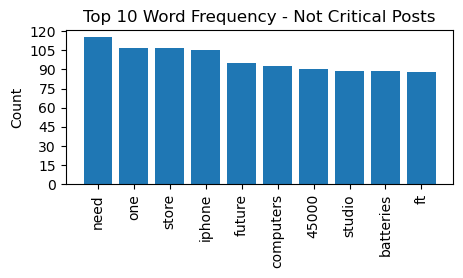

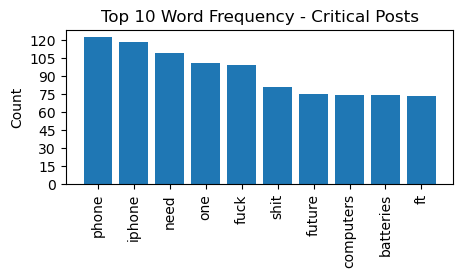

In [15]:
for i in range(0,2):
    visualize_top_ten_tokens_per_sentiment('sentiment',i,'text_stopwords_removed')
    plt.savefig(f"./images/df_10word_freq_rating{i}_stopwords.png", dpi=150)

# Modeling

## Baseline Model 

For the baseline model a Naive Bayes Model will be used. 

In [16]:
#split the features and target into train and test sets for modeling.

from sklearn.model_selection import train_test_split


y = df['sentiment']
X = df['text_cleaned']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.2, random_state = 30)

In [17]:
# Create Pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

#define pipline
pipe1 = Pipeline([('tfidf', TfidfVectorizer(max_features=2000,
                                            stop_words=stopwords_list,
                                            token_pattern = token_pattern)),
                  ('MNB',MultinomialNB())
                 ])

#fit pieline to train data
pipe1.fit(X_train, y_train)

#check score on baseline model
pipe1.score(X_test, y_test)

0.8081841432225064

When checking for critical and not critical posts, it is more beneficial to minimize the number of false negatives. Therefore, the recall score of the model should be considered. 

In [18]:
#Check Recall Score
from sklearn.metrics import recall_score

y_train_pred = pipe1.predict(X_train)
y_test_pred = pipe1.predict(X_test)
print('Training Recall: ', recall_score(y_train, y_train_pred))
print('Testing Recall: ', recall_score(y_test, y_test_pred))

Training Recall:  0.8765306122448979
Testing Recall:  0.8031914893617021


The baseline model has high recall scores between both the training and testing data. This shows that model is performing well. The training data has a slightly larger recall score which means the model is slightly overfitting to the training model. However, this is not a large difference and the high testing recall score is still good. 

## Model 2: Lemmatizing Words

For the second iteration of the model, the tokens will be lemmatized to see if this can improve the model's performance.

In [19]:
from nltk.stem.wordnet import WordNetLemmatizer

#Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [lemmatizer.lemmatize(token) for token in tokens]

#lemamtize stopwords
lemmatized_stopwords = [lemmatizer.lemmatize(word) for word in stopwords_list]

#define pipeline
pipe2 = Pipeline([('tfidf', TfidfVectorizer(max_features=2000,
                                            stop_words=lemmatized_stopwords,
                                            tokenizer = lemmatize_tokenize,
                                            token_pattern=None)),
                  ('MNB',MultinomialNB())
                 ])

#fit and transform train data
pipe2.fit(X_train, y_train)

#Check score of model 2
pipe2.score(X_test, y_test)

0.7953964194373402

In [20]:
#Check Recall Score
y_train_pred = pipe2.predict(X_train)
y_test_pred = pipe2.predict(X_test)
print('Model 2 Training Recall: ', recall_score(y_train, y_train_pred))
print('Model 2 Testing Recall: ', recall_score(y_test, y_test_pred))

Model 2 Training Recall:  0.8755102040816326
Model 2 Testing Recall:  0.7925531914893617


Results are very similar to Model 1.

## Model 3: Random Forest Model

For the next iteration, a more complex Random Forest Model will be test to see if this improves model performance.

In [21]:
#Make Baseline Random Forest Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#define pipeline
pipe3 = Pipeline([('tfidf', TfidfVectorizer(max_features=2000,
                                            stop_words=lemmatized_stopwords,
                                            tokenizer = lemmatize_tokenize,
                                            token_pattern=None)),
                  ('RF', RandomForestClassifier(random_state = 42))
                 ])

# Define the grid
param_grid = {
    'RF__n_estimators': [50, 100, 200],
    'RF__max_depth': [3, 5, 10],
    'RF__min_samples_split': [2, 5, 10],
    'RF__min_samples_leaf': [1, 2, 4],}

# Define a grid search
gridsearch = GridSearchCV(pipe3,param_grid,scoring = 'recall', cv = 5,return_train_score = True)

# Fit the training data
gridsearch.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=2000,
                                                        stop_words=['i', 'me',
                                                                    'my',
                                                                    'myself',
                                                                    'we', 'our',
                                                                    'ours',
                                                                    'ourselves',
                                                                    'you',
                                                                    "you're",
                                                                    "you've",
                                                                    "you'll",
                                                                    "you'd",
                                                                    'your',
                                                                    'yours',
                                                                    'yourself',
                                                                    'yourselves',
                                                                    'he', 'him',
                                                                    'his',
                                                                    'himself',
                                                                    'she',
                                                                    "she's",
                                                                    'her',
                                                                    'hers',
                                                                    'herself',
                                                                    'it',
                                                                    "it's",
                                                                    'it',
                                                                    'itself', ...],
                                                        token_pattern=None,
                                                        tokenizer=<function lemmatize_tokenize at 0x146c1b5e0>)),
                                       ('RF',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'RF__max_depth': [3, 5, 10],
                         'RF__min_samples_leaf': [1, 2, 4],
                         'RF__min_samples_split': [2, 5, 10],
                         'RF__n_estimators': [50, 100, 200]},
             return_train_score=True, scoring='recall')

In [22]:
# Check average score of gridsearch results
pipe3_train_mean_score = np.mean(gridsearch.cv_results_["mean_train_score"])
pipe3_test_mean_score = gridsearch.score(X_test, y_test)
pipe3_val_mean_score = gridsearch.score(X_val, y_val)

print(f"Mean Training Recall Score: {pipe3_train_mean_score :.2%}")
print(f"Mean Test Recall Score: {pipe3_test_mean_score :.2%}")
print(f"Mean Val Recall Score: {pipe3_val_mean_score :.2%}")
print("Best Parameter Combination Found During Grid Search:",gridsearch.best_params_)

Mean Training Recall Score: 77.08%
Mean Test Recall Score: 79.79%
Mean Val Recall Score: 72.55%
Best Parameter Combination Found During Grid Search: {'RF__max_depth': 3, 'RF__min_samples_leaf': 4, 'RF__min_samples_split': 2, 'RF__n_estimators': 200}


The training and test scores are very close to each other and still close to 80%. This shows that the model is performing well and is not overfitting. The Validation score is a bit lower but still within 5% of the training recall score so I think this shows that the selected best parameter combination will produce a quality model.

## Final Model

Create final model based on the results of the the iterations. The random forest model with the optimized parameters had the best results and will be used for this final model.

In [23]:
#Define Final Model
final_model = Pipeline([('tfidf', TfidfVectorizer(max_features=2000,
                                            stop_words=lemmatized_stopwords,
                                            tokenizer = lemmatize_tokenize,
                                            token_pattern=None)),
                  ('RF', RandomForestClassifier(max_depth = 3,
                                                min_samples_leaf = 4,
                                                min_samples_split = 2,
                                                n_estimators = 200,
                                                random_state = 42))
                 ])

#fit model to the train data
final_model.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000,
                                 stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'it', 'itself', ...],
                                 token_pattern=None,
                                 tokenizer=<function lemmatize_tokenize at 0x146c1b5e0>)),
                ('RF',
                 RandomForestClassifier(max_depth=3, min_samples_leaf=4,
                                        n_estimators=200, random_state=42))])

In [24]:
#Check recall scores of final model
final_y_train_pred = final_model.predict(X_train)
final_y_test_pred = final_model.predict(X_test)

print('Training Recall: ', recall_score(y_train, final_y_train_pred))
print('Testing Recall: ', recall_score(y_test, final_y_test_pred))

Training Recall:  0.8193877551020409
Testing Recall:  0.7978723404255319


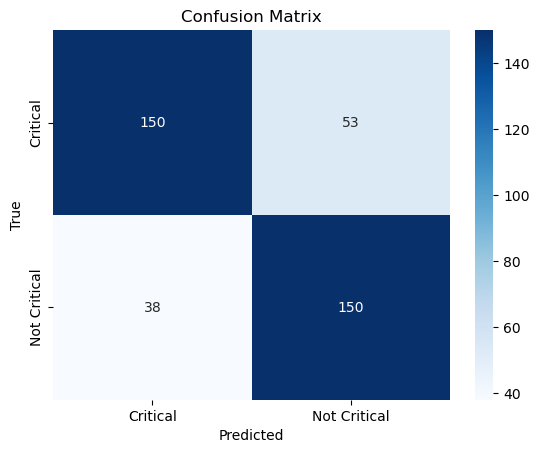

In [28]:
#Make Confusion Matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

cm = confusion_matrix(y_test, final_y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels = ['Critical','Not Critical'],yticklabels = ['Critical','Not Critical'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("./images/confusion_matrix.png", dpi=150)
plt.show();

# Conclusion

## Limitations

## Recommendations

## Next Steps